<a href="https://colab.research.google.com/github/shuaigezhu/starDist/blob/master/NP_CONV_UNiform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from random import randint
import glob
import scipy
import seaborn as sns
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

Using TensorFlow backend.


# MLP

In [0]:
def batch_mlp(input, output_sizes, variable_scope):
  """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).
  
  Args:
    input: input tensor of shape [B,n,d_in].
    output_sizes: An iterable containing the output sizes of the MLP as defined 
        in `basic.Linear`.
    variable_scope: String giving the name of the variable scope. If this is set
        to be the same as a previously defined MLP, then the weights are reused.
    
  Returns:
    tensor of shape [B,n,d_out] where d_out=output_sizes[-1]
  """
  # Get the shapes of the input and reshape to parallelise across observations
  batch_size, _, filter_size = input.shape.as_list()
  output = tf.reshape(input, (-1, filter_size))
  output.set_shape((None, filter_size))

  # Pass through MLP
  with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
    for i, size in enumerate(output_sizes[:-1]):
      output = tf.nn.relu(
          tf.layers.dense(output, size, name="layer_{}".format(i)))

    # Last layer without a ReLu
    output = tf.layers.dense(
        output, output_sizes[-1], name="layer_{}".format(i + 1))

  # Bring back into original shape
  output = tf.reshape(output, (batch_size, -1, output_sizes[-1]))
  return output

### **Deterministic Encoder**

In [0]:
class DeterministicEncoder(object):
  """The Deterministic Encoder."""

  def __init__(self, output_sizes, attention):
    """(A)NP deterministic encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      attention: The attention module.
    """
    self._output_sizes = output_sizes
    self._attention = attention

  def __call__(self, context_x, context_y, target_x):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.
      target_x: Tensor of shape [B,target_observations,d_x]. 
          For this 1D regression task this corresponds to the x-values.

    Returns:
      The encoded representation. Tensor of shape [B,target_observations,d]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, 
                       "deterministic_encoder")

    # Apply attention
    with tf.variable_scope("deterministic_encoder", reuse=tf.AUTO_REUSE):
        hidden = self._attention(context_x, target_x, hidden)

    return hidden

### **Latent Encoder**

In [0]:
class LatentEncoder(object):
  """The Latent Encoder."""

  def __init__(self, output_sizes, num_latents):
    """(A)NP latent encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      num_latents: The latent dimensionality.
    """
    self._output_sizes = output_sizes
    self._num_latents = num_latents

  def __call__(self, x, y):
    """Encodes the inputs into one representation.

    Args:
      x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.

    Returns:
      A normal distribution over tensors of shape [B, num_latents]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([x, y], axis=-1)

    # Pass final axis through MLP
    print('encoder')
    print(encoder_input.shape)
    hidden = batch_mlp(encoder_input, self._output_sizes, "latent_encoder")
    
    # Aggregator: take the mean over all points
    hidden = tf.reduce_mean(hidden, axis=1)
    
    # Have further MLP layers that map to the parameters of the Gaussian latent
    with tf.variable_scope("latent_encoder", reuse=tf.AUTO_REUSE):
      # First apply intermediate relu layer 
      hidden = tf.nn.relu(
          tf.layers.dense(hidden, 
                          (self._output_sizes[-1] + self._num_latents)/2,
                          name="penultimate_layer"))
      # Then apply further linear layers to output latent mu and log sigma
      mu = tf.layers.dense(hidden, self._num_latents, name="mean_layer")
      log_sigma = tf.layers.dense(hidden, self._num_latents, name="std_layer")
      
    # Compute sigma
    sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)

    return tf.contrib.distributions.Normal(loc=mu, scale=sigma)

### **Decoder**

In [0]:
class Decoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """(A)NP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x):
    """Decodes the individual targets.

    Args:
      representation: The representation of the context for target predictions. 
          Tensor of shape [B,target_observations,?].
      target_x: The x locations for the target query.
          Tensor of shape [B,target_observations,d_x].

    Returns:
      dist: A multivariate Gaussian over the target points. A distribution over
          tensors of shape [B,target_observations,d_y].
      mu: The mean of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
      sigma: The standard deviation of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
    """
    # concatenate target_x and representation
    hidden = tf.concat([representation, target_x], axis=-1)

    print('decoder')
    print(hidden.shape)
    # Pass final axis through MLP
    hidden = batch_mlp(hidden, self._output_sizes, "decoder")

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

### **Model**

In [0]:
class LatentModel(object):
  """The (A)NP model."""

  def __init__(self, latent_encoder_output_sizes, num_latents,
               decoder_output_sizes, use_deterministic_path=True, 
               deterministic_encoder_output_sizes=None, attention=None):
    """Initialises the model.

    Args:
      latent_encoder_output_sizes: An iterable containing the sizes of hidden 
          layers of the latent encoder.
      num_latents: The latent dimensionality.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to d_y * 2
          (it encodes both mean and variance concatenated)
      use_deterministic_path: a boolean that indicates whether the deterministic
          encoder is used or not.
      deterministic_encoder_output_sizes: An iterable containing the sizes of 
          hidden layers of the deterministic encoder. The last one is the size 
          of the deterministic representation r.
      attention: The attention module used in the deterministic encoder.
          Only relevant when use_deterministic_path=True.
    """
    self._latent_encoder = LatentEncoder(latent_encoder_output_sizes, 
                                         num_latents)
    self._decoder = Decoder(decoder_output_sizes)
    self._use_deterministic_path = use_deterministic_path
    if use_deterministic_path:
      self._deterministic_encoder = DeterministicEncoder(
          deterministic_encoder_output_sizes, attention)
    

  def __call__(self, query, num_targets, target_y=None, test_target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Tensor of shape [B,num_contexts,d_x]. 
              Contains the x values of the context points.
          context_y: Tensor of shape [B,num_contexts,d_y]. 
              Contains the y values of the context points.
          target_x: Tensor of shape [B,num_targets,d_x]. 
              Contains the x values of the target points.
      num_targets: Number of target points.
      target_y: The ground truth y values of the target y. 
          Tensor of shape [B,num_targets,d_y].

    Returns:
      log_p: The log_probability of the target_y given the predicted
          distribution. Tensor of shape [B,num_targets].
      mu: The mean of the predicted distribution. 
          Tensor of shape [B,num_targets,d_y].
      sigma: The variance of the predicted distribution.
          Tensor of shape [B,num_targets,d_y].
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    prior = self._latent_encoder(context_x, context_y)
    
    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    if target_y is None:
      latent_rep = prior.sample()
    # For testing, when target_y unavailable, use contexts for latent encoder.
    else:
      posterior = self._latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()
    latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                         [1, num_targets, 1])
    if self._use_deterministic_path:
      deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                      target_x)
      representation = tf.concat([deterministic_rep, latent_rep], axis=-1)
    else:
      representation = latent_rep
      
    dist, mu, sigma = self._decoder(representation, target_x)
    
    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      posterior = self._latent_encoder(target_x, target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      LL = tf.reduce_mean(log_p, keep_dims=False)
    else:
      log_p = dist.log_prob(test_target_y)
      posterior = self._latent_encoder(target_x, test_target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      #validation_context_loss = - tf.reduce_mean(log_p[:,int(0.5*num_targets):] - kl / tf.cast(num_targets, tf.float32))
      #validation_noncontext_loss =  - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      LL = None
        #con_y = pred_y[:,:int(0.5 * test_num_total_points)] - target_y[:,:int(0.5 * test_num_total_points)]
      #tar_y = pred_y[:,int(0.5 * test_num_total_points):] - target_y[:,int(0.5 * test_num_total_points):]

    return mu, sigma, log_p, LL, kl, loss

### **Attention**

In [0]:
def uniform_attention(q, v):
  """Uniform attention. Equivalent to np.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    v: values. tensor of shape [B,n,d_v].
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  total_points = tf.shape(q)[1]
  rep = tf.reduce_mean(v, axis=1, keepdims=True)  # [B,1,d_v]
  rep = tf.tile(rep, [1, total_points, 1])
  return rep

def laplace_attention(q, k, v, scale, normalise):
  """Computes laplace exponential attention.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    scale: float that scales the L1 distance.
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  k = tf.expand_dims(k, axis=1)  # [B,1,n,d_k]
  q = tf.expand_dims(q, axis=2)  # [B,m,1,d_k]
  unnorm_weights = - tf.abs((k - q) / scale)  # [B,m,n,d_k]
  unnorm_weights = tf.reduce_sum(unnorm_weights, axis=-1)  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = lambda x: 1 + tf.tanh(x)
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def dot_product_attention(q, k, v, normalise):
  """Computes dot product attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = tf.shape(q)[-1]
  scale = tf.sqrt(tf.cast(d_k, tf.float32))
  unnorm_weights = tf.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = tf.sigmoid
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def multihead_attention(q, k, v, num_heads=8):
  """Computes multi-head attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    num_heads: number of heads. Should divide d_v.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = q.get_shape().as_list()[-1]
  d_v = v.get_shape().as_list()[-1]
  head_size = d_v / num_heads
  key_initializer = tf.random_normal_initializer(stddev=d_k**-0.5)
  value_initializer = tf.random_normal_initializer(stddev=d_v**-0.5)
  rep = tf.constant(0.0)
  for h in range(num_heads):
    o = dot_product_attention(
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wq%d' % h, use_bias=False, padding='VALID')(q),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wk%d' % h, use_bias=False, padding='VALID')(k),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wv%d' % h, use_bias=False, padding='VALID')(v),
        normalise=True)
    rep += tf.layers.Conv1D(d_v, 1, kernel_initializer=value_initializer,
                      name='wo%d' % h, use_bias=False, padding='VALID')(o)
  return rep

class Attention(object):
  """The Attention module."""

  def __init__(self, rep, output_sizes, att_type, scale=1., normalise=True,
               num_heads=8):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention. 
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalise: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self._rep = rep
    self._output_sizes = output_sizes
    self._type = att_type
    self._scale = scale
    self._normalise = normalise
    if self._type == 'multihead':
      self._num_heads = num_heads

  def __call__(self, x1, x2, r):
    """Apply attention to create aggregated representation of r.

    Args:
      x1: tensor of shape [B,n1,d_x].
      x2: tensor of shape [B,n2,d_x].
      r: tensor of shape [B,n1,d].
      
    Returns:
      tensor of shape [B,n2,d]

    Raises:
      NameError: The argument for rep/type was invalid.
    """
    if self._rep == 'identity':
      k, q = (x1, x2)
    elif self._rep == 'mlp':
      # Pass through MLP
      k = batch_mlp(x1, self._output_sizes, "attention")
      q = batch_mlp(x2, self._output_sizes, "attention")
    else:
      raise NameError("'rep' not among ['identity','mlp']")

    if self._type == 'uniform':
      rep = uniform_attention(q, r)
    elif self._type == 'laplace':
      rep = laplace_attention(q, k, r, self._scale, self._normalise)
    elif self._type == 'dot_product':
      rep = dot_product_attention(q, k, r, self._normalise)
    elif self._type == 'multihead':
      rep = multihead_attention(q, k, r, self._num_heads)
    else:
      raise NameError(("'att_type' not among ['uniform','laplace','dot_product'"
                       ",'multihead']"))

    return rep

In [0]:
def Normalization_old(data):
  data_f = data.astype(float)
  data_mean = np.mean(data_f, axis=0, keepdims=True)
  data_n = data_f - data_mean
  data_range = np.max(np.abs(data_n), axis=0, keepdims=True)
  data_n = data_n / data_range
  
  return data_n

def datawrap(data_x, data_y, batch_size):
  num_target = 0
  num_context = 50
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=False)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)[:,:num_context+num_target,:]
  target_y = np.array(batch_datay)[:,:num_context+num_target,:]
  
    #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = num_context+num_target
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

def testdatawrap(data_x, data_y, batch_size):
  num_target = 50
  ratio_ct = 0.7
  num_context = int(ratio_ct * batch_size)
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=False)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]#context is belong to target
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)#x values
  target_y = np.array(batch_datay)#y values
  
  #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = batch_size 
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

# Data Selector

In [0]:
filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/refcat_yufengzhu.csv"
df = pd.read_csv(filename)

gaia_selected = df.loc[(df['dplx'] <= 0.1) 
                       & (df['plx'] <= 5) & (df['plx'] > 0)]
print(gaia_selected.shape)

indexNames = gaia_selected[gaia_selected['Gaia'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

indexNames = gaia_selected[gaia_selected['BP'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

indexNames = gaia_selected[gaia_selected['RP'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['g'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['i'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['r'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['z'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

(66619, 45)


/home/yufeng/jupyter_py3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#gaia_selected = Normalization_old(np.array(gaia_selected))
gaia_selected = np.array(gaia_selected)
gaia_selected = pd.DataFrame(gaia_selected)

g_mag = gaia_selected.loc[:, [1, 2, 9, 3]]
#g_mag = g_mag.rename(columns={'Gaia':"mag"})
g_mag = g_mag.dropna()

bp_mag = gaia_selected.loc[:, [1, 2, 11, 3]]
#bp_mag = bp_mag.rename(columns={'BP':"mag"})
bp_mag = bp_mag.dropna()

rp_mag = gaia_selected.loc[:, [1, 2, 13, 3]]
#rp_mag = rp_mag.rename(columns={'RP':"mag"})
rp_mag = rp_mag.dropna()

i_mag = gaia_selected.loc[:, [1, 2,30, 3]]
#i_mag = i_mag.rename(columns={'i':"mag"})
i_mag = i_mag.dropna()

gg_mag = gaia_selected.loc[:, [1, 2,22, 3]]
#gg_mag = gg_mag.rename(columns={'g':"mag"})
gg_mag = gg_mag.dropna()

r_mag = gaia_selected.loc[:, [1, 2,26, 3]]
#r_mag = r_mag.rename(columns={'r':"mag"})
r_mag = r_mag.dropna()

g_mag ['wavelength'] = -0.160976190476 #5857.6
bp_mag ['wavelength'] = -0.354516666667 #5044.4
rp_mag ['wavelength'] = 0.275911904762 #7692.2
gg_mag['wavelength'] = -0.410111904762 #4810.9
r_mag['wavelength'] = -0.0897785714286 #6156.3
i_mag['wavelength'] = 0.231030952381 #7503.7
#z_mag['wavelength'] =  0.508364285714 #8668.5

g_mag = np.array(g_mag)
bp_mag = np.array(bp_mag)
rp_mag = np.array(rp_mag)
#mag norm
g_mag[:,2] = (g_mag[:,2]-16)/17
bp_mag[:,2] = (bp_mag[:,2]-16)/17
rp_mag[:,2] = (rp_mag[:,2]-16)/17
# ra norm
g_mag[:,0] = (g_mag[:,0]-3)/6
bp_mag[:,0] = (bp_mag[:,0]-3)/6
rp_mag[:,0] = (rp_mag[:,0]-3)/6
# dec norm
g_mag[:,1] = (g_mag[:,1]-0.008)/2.5
bp_mag[:,1] = (bp_mag[:,1]-0.008)/2.5
rp_mag[:,1] = (rp_mag[:,1]-0.008)/2.5


gg_mag = np.array(gg_mag)
r_mag = np.array(r_mag)
i_mag = np.array(i_mag)

gg_mag[:,2] = (gg_mag[:,2]-16)/17
r_mag[:,2] = (r_mag[:,2]-16)/17
i_mag[:,2] = (i_mag[:,2]-16)/17

# ra norm
gg_mag[:,0] = (gg_mag[:,0]-3)/6
r_mag[:,0] = (r_mag[:,0]-3)/6
i_mag[:,0] = (i_mag[:,0]-3)/6
# dec norm
gg_mag[:,1] = (gg_mag[:,1]-0.008)/2.5
r_mag[:,1] = (r_mag[:,1]-0.008)/2.5
i_mag[:,1] = (i_mag[:,1]-0.008)/2.5


all_df = []
for i in range(g_mag.shape[0]):
    row = []
    for j in range(g_mag.shape[1]):
        #tmp = [g_mag[i][j]]+[bp_mag[i][j]]+[rp_mag[i][j]]
        #tmp = [gg_mag[i][j]]+[r_mag[i][j]]+[rp_mag[i][j]]
        tmp = [bp_mag[i][j]]+[g_mag[i][j]]+[i_mag[i][j]]
        #tmp = [bp_mag[i][j]]
        #tmp = [rp_mag[i][j]]+[r_mag[i][j]]+[gg_mag[i][j]]
        #tmp = [rp_mag[i][j]] + [gg_mag[i][j]] + [r_mag[i][j]]
        row.append(tmp)
    all_df.append(row)

all_df = np.array(all_df)

y_df = all_df[:,3,0]
x_df = all_df[:,[0,1,2,4],:]

x_df = np.reshape(x_df,(x_df.shape[0],x_df.shape[1], x_df.shape[2], 1))
y_df = np.reshape(y_df,(-1, 1))

y_df = (y_df-1.25)/5

ratio = 0.95 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_norm_x = np.array(train_x)
test_norm_x = np.array(test_x)

test_norm_y = np.array(test_y)
train_norm_y =np.array(train_y)

train_norm_x = np.array(train_norm_x).astype(float)
train_norm_y = np.array(train_norm_y).astype(float)
test_norm_x = np.array(test_norm_x).astype(float)
test_norm_y = np.array(test_norm_y).astype(float)

print(train_norm_x.shape)

test_norm_x = pan_test_norm_x
test_norm_y = pan_test_norm_y

print(test_norm_x.shape)

(63170, 4, 3, 1)
(6674, 4, 3, 1)


In [0]:
g_mag = gaia_selected.loc[:, [1, 2, 9, 3]]
#g_mag = g_mag.rename(columns={'Gaia':"mag"})
g_mag = g_mag.dropna()

bp_mag = gaia_selected.loc[:, [1, 2, 11, 3]]
#bp_mag = bp_mag.rename(columns={'BP':"mag"})
bp_mag = bp_mag.dropna()

rp_mag = gaia_selected.loc[:, [1, 2, 13, 3]]
#rp_mag = rp_mag.rename(columns={'RP':"mag"})
rp_mag = rp_mag.dropna()

i_mag = gaia_selected.loc[:, [1, 2,30, 3]]
#i_mag = i_mag.rename(columns={'i':"mag"})
i_mag = i_mag.dropna()

gg_mag = gaia_selected.loc[:, [1, 2,22, 3]]
#gg_mag = gg_mag.rename(columns={'g':"mag"})
gg_mag = gg_mag.dropna()

r_mag = gaia_selected.loc[:, [1, 2,26, 3]]
#r_mag = r_mag.rename(columns={'r':"mag"})
r_mag = r_mag.dropna()


g_mag ['wavelength'] = -0.160976190476 #5857.6
bp_mag ['wavelength'] = -0.354516666667 #5044.4
rp_mag ['wavelength'] = 0.275911904762 #7692.2
gg_mag['wavelength'] = -0.410111904762 #4810.9
r_mag['wavelength'] = -0.0897785714286 #6156.3
i_mag['wavelength'] = 0.231030952381 #7503.7
#z_mag['wavelength'] =  0.508364285714 #8668.5

g_mag = np.array(g_mag)
bp_mag = np.array(bp_mag)
rp_mag = np.array(rp_mag)
#mag norm
g_mag[:,2] = (g_mag[:,2]-16)/17
bp_mag[:,2] = (bp_mag[:,2]-16)/17
rp_mag[:,2] = (rp_mag[:,2]-16)/17
# ra norm
g_mag[:,0] = (g_mag[:,0]-3)/6
bp_mag[:,0] = (bp_mag[:,0]-3)/6
rp_mag[:,0] = (rp_mag[:,0]-3)/6
# dec norm
g_mag[:,1] = (g_mag[:,1]-0.008)/2.5
bp_mag[:,1] = (bp_mag[:,1]-0.008)/2.5
rp_mag[:,1] = (rp_mag[:,1]-0.008)/2.5

gg_mag = np.array(gg_mag)
r_mag = np.array(r_mag)
i_mag = np.array(i_mag)

gg_mag[:,2] = (gg_mag[:,2]-16)/17
r_mag[:,2] = (r_mag[:,2]-16)/17
i_mag[:,2] = (i_mag[:,2]-16)/17

# ra norm
gg_mag[:,0] = (gg_mag[:,0]-3)/6
r_mag[:,0] = (r_mag[:,0]-3)/6
i_mag[:,0] = (i_mag[:,0]-3)/6
# dec norm
gg_mag[:,1] = (gg_mag[:,1]-0.008)/2.5
r_mag[:,1] = (r_mag[:,1]-0.008)/2.5
i_mag[:,1] = (i_mag[:,1]-0.008)/2.5

all_df = []
for i in range(g_mag.shape[0]):
    row = []
    for j in range(g_mag.shape[1]):
        #tmp = [gg_mag[i][j]]+[r_mag[i][j]]+[i_mag[i][j]]
        #tmp = [gg_mag[i][j]]+[i_mag[i][j]]+[r_mag[i][j]]
        #tmp = [bp_mag[i][j]]+[g_mag[i][j]]+[i_mag[i][j]]
        tmp = [bp_mag[i][j]]+[g_mag[i][j]] + [bp_mag[i][j]]
        #tmp = [gg_mag[i][j]] + [gg_mag[i][j]] + [gg_mag[i][j]]
        #tmp = [gg_mag[i][j]]+[r_mag[i][j]]
        row.append(tmp)
    all_df.append(row)

all_df = np.array(all_df)

y_df = all_df[:,3,0]
x_df = all_df[:,[0,1,2,4],:]

x_df = np.reshape(x_df,(x_df.shape[0],x_df.shape[1], x_df.shape[2], 1))
y_df = np.reshape(y_df,(-1, 1))

y_df = (y_df-1.25)/5

ratio = 0.9 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_norm_x = np.array(train_x)
test_norm_x = np.array(test_x)

test_norm_y = np.array(test_y)
train_norm_y =np.array(train_y)

train_norm_x = np.array(train_norm_x).astype(float)
train_norm_y = np.array(train_norm_y).astype(float)
test_norm_x = np.array(test_norm_x).astype(float)
test_norm_y = np.array(test_norm_y).astype(float)

print(train_norm_x.shape)
print(test_norm_x.shape)
pan_test_norm_x = test_norm_x
pan_test_norm_y = test_norm_y

(59799, 4, 3, 1)
(6674, 4, 3, 1)


# all in one row

In [0]:
filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/refcat_yufengzhu.csv"
df = pd.read_csv(filename)

gaia_selected = df.loc[(df['dplx'] <= 0.2) 
                       & (df['plx'] <= 5) & (df['plx'] > 0)]

new_df = gaia_selected.loc[:, ['RA', 'Dec','Gaia','BP','RP','g','i','r','z','plx']]

x_df = new_df.loc[:,['RA', 'Dec','Gaia','BP','RP','g','i','r','z']]
y_df = new_df.loc[:,['plx']]

indexNames = x_df[x_df['Gaia'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['BP'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['RP'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['g'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['i'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['r'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['z'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

x_df = new_df.loc[:,['RA', 'Dec','g','r','RP']]
y_df = new_df.loc[:,['plx']]

#x_df ['g_wavelength'] = -0.160976190476 #5857.6
#x_df ['bp_wavelength'] = -0.354516666667 #5044.4

x_df ['gg_wavelength'] = -0.410111904762 #4810.9
x_df ['r_wavelength'] = -0.0897785714286 #6156.3
x_df ['rp_wavelength'] = 0.275911904762 #7692.2
#x_df ['i_wavelength'] = 0.231030952381 #7503.7

x_df['RA'] = (x_df['RA']-3)/60
x_df['Dec'] = (x_df['Dec']-0.008)/2.5
x_df['g'] = (x_df['g']-16)/17
x_df['r'] = (x_df['r']-16)/17
x_df['RP'] = (x_df['RP']-16)/17

y_df['plx'] = (y_df['plx']-1.25)/5

ratio = 0.9 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_norm_x = np.array(train_x)
test_norm_x = np.array(test_x)

test_norm_y = np.array(test_y)
train_norm_y =np.array(train_y)

train_norm_x = np.array(train_norm_x).astype(float)
train_norm_y = np.array(train_norm_y).astype(float)
test_norm_x = np.array(test_norm_x).astype(float)
test_norm_y = np.array(test_norm_y).astype(float)

print(train_norm_x.shape)
print(test_norm_x.shape)

test_norm_x = pan_test_norm_x
test_norm_y = pan_test_norm_y

(103900, 8)
(11513, 8)


In [0]:
filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/refcat_yufengzhu.csv"
df = pd.read_csv(filename)

gaia_selected = df.loc[(df['dplx'] <= 0.2) 
                       & (df['plx'] <= 5) & (df['plx'] > 0)]

new_df = gaia_selected.loc[:, ['RA', 'Dec','Gaia','BP','RP','g','i','r','z','plx']]

x_df = new_df.loc[:,['RA', 'Dec','Gaia','BP','RP','g','i','r','z']]
y_df = new_df.loc[:,['plx']]

indexNames = x_df[x_df['Gaia'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['BP'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['RP'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['g'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['i'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['r'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

indexNames = x_df[x_df['z'] <= 0.].index
x_df.drop(indexNames, inplace=True)
y_df.drop(indexNames, inplace=True)

x_df = new_df.loc[:,['RA', 'Dec','BP','Gaia','i']]
y_df = new_df.loc[:,['plx']]


x_df ['bp_wavelength'] = -0.354516666667 #5044.4
x_df ['g_wavelength'] = -0.160976190476 #5857.6
#x_df ['rp_wavelength'] = 0.275911904762 #7692.2
#x_df ['gg_wavelength'] = -0.410111904762 #4810.9
#x_df ['r_wavelength'] = -0.0897785714286 #6156.3
x_df ['i_wavelength'] = 0.231030952381 #7503.7

x_df['RA'] = (x_df['RA']-3)/60
x_df['Dec'] = (x_df['Dec']-0.008)/2.5
x_df['BP'] = (x_df['BP']-16)/17
x_df['Gaia'] = (x_df['Gaia']-16)/17
x_df['i'] = (x_df['i']-16)/17

y_df['plx'] = (y_df['plx']-1.25)/5

ratio = 0.9 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_norm_x = np.array(train_x)
test_norm_x = np.array(test_x)

test_norm_y = np.array(test_y)
train_norm_y =np.array(train_y)

train_norm_x = np.array(train_norm_x).astype(float)
train_norm_y = np.array(train_norm_y).astype(float)
test_norm_x = np.array(test_norm_x).astype(float)
test_norm_y = np.array(test_norm_y).astype(float)

print(train_norm_x.shape)
print(test_norm_x.shape)

pan_test_norm_x = test_norm_x 
pan_test_norm_y = test_norm_y

(103964, 8)
(11449, 8)


# dim = {Ra, Dec, Mag, Wav}

In [0]:
filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/refcat_yufengzhu.csv"
df = pd.read_csv(filename)

gaia_selected = df.loc[(df['dplx'] <= 0.1) 
                       & (df['plx'] <= 5) & (df['plx'] > 0)]

indexNames = gaia_selected[gaia_selected['Gaia'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

indexNames = gaia_selected[gaia_selected['BP'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

indexNames = gaia_selected[gaia_selected['RP'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['g'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['i'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['r'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['z'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

#gaia_selected = Normalization_old(np.array(gaia_selected))
gaia_selected = np.array(gaia_selected)
gaia_selected = pd.DataFrame(gaia_selected)

g_mag = gaia_selected.loc[:, [1, 2, 9, 3]]
#g_mag = g_mag.rename(columns={'Gaia':"mag"})
g_mag = g_mag.dropna()

bp_mag = gaia_selected.loc[:, [1, 2, 11, 3]]
#bp_mag = bp_mag.rename(columns={'BP':"mag"})
bp_mag = bp_mag.dropna()

rp_mag = gaia_selected.loc[:, [1, 2, 13, 3]]
#rp_mag = rp_mag.rename(columns={'RP':"mag"})
rp_mag = rp_mag.dropna()

i_mag = gaia_selected.loc[:, [1, 2,30, 3]]
#i_mag = i_mag.rename(columns={'i':"mag"})
i_mag = i_mag.dropna()

gg_mag = gaia_selected.loc[:, [1, 2,22, 3]]
#gg_mag = gg_mag.rename(columns={'g':"mag"})
gg_mag = gg_mag.dropna()

r_mag = gaia_selected.loc[:, [1, 2,26, 3]]
#r_mag = r_mag.rename(columns={'r':"mag"})
r_mag = r_mag.dropna()

z_mag = gaia_selected.loc[:, [1, 2,26, 3]]
#r_mag = r_mag.rename(columns={'r':"mag"})
z_mag = z_mag.dropna()

g_mag ['wavelength'] = -0.160976190476 #5857.6
bp_mag ['wavelength'] = -0.354516666667 #5044.4
rp_mag ['wavelength'] = 0.275911904762 #7692.2
gg_mag['wavelength'] = -0.410111904762 #4810.9
r_mag['wavelength'] = -0.0897785714286 #6156.3
i_mag['wavelength'] = 0.231030952381 #7503.7
z_mag['wavelength'] =  0.508364285714 #8668.5

g_mag = np.array(g_mag)
bp_mag = np.array(bp_mag)
rp_mag = np.array(rp_mag)
z_mag = np.array(z_mag)
#mag norm
g_mag[:,2] = (g_mag[:,2]-16)/17
bp_mag[:,2] = (bp_mag[:,2]-16)/17
rp_mag[:,2] = (rp_mag[:,2]-16)/17
z_mag[:,2] = (z_mag[:,2]-16)/17
# ra norm
g_mag[:,0] = (g_mag[:,0]-3)/60
bp_mag[:,0] = (bp_mag[:,0]-3)/60
rp_mag[:,0] = (rp_mag[:,0]-3)/60
z_mag[:,0] = (z_mag[:,0]-3)/60
# dec norm
g_mag[:,1] = (g_mag[:,1]-0.008)/2.5
bp_mag[:,1] = (bp_mag[:,1]-0.008)/2.5
rp_mag[:,1] = (rp_mag[:,1]-0.008)/2.5
z_mag[:,1] = (z_mag[:,1]-0.008)/2.5


gg_mag = np.array(gg_mag)
r_mag = np.array(r_mag)
i_mag = np.array(i_mag)

gg_mag[:,2] = (gg_mag[:,2]-16)/17
r_mag[:,2] = (r_mag[:,2]-16)/17
i_mag[:,2] = (i_mag[:,2]-16)/17

# ra norm
gg_mag[:,0] = (gg_mag[:,0]-3)/60
r_mag[:,0] = (r_mag[:,0]-3)/60
i_mag[:,0] = (i_mag[:,0]-3)/60
# dec norm
gg_mag[:,1] = (gg_mag[:,1]-0.008)/2.5
r_mag[:,1] = (r_mag[:,1]-0.008)/2.5
i_mag[:,1] = (i_mag[:,1]-0.008)/2.5

all_df = []

for i in range(g_mag.shape[0]):
    row = []
    row.append(g_mag[i])
    row.append(gg_mag[i])   
    row.append(i_mag[i])    
    row.append(bp_mag[i])
    row.append(r_mag[i])
    row.append(rp_mag[i])
    row.append(z_mag[i])
    all_df.append(row)

all_df = np.array(all_df)

x_df = all_df[:,:,[0,1,2,4]]
y_df = all_df[:,0,[3]]

# norm y
y_df = (y_df-1.25)/5

x_df = np.reshape(x_df, (x_df.shape[0], 1, x_df.shape[1], x_df.shape[2]))

ratio = 0.9 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_norm_x = np.array(train_x)
test_norm_x = np.array(test_x)

test_norm_y = np.array(test_y)
train_norm_y = np.array(train_y)

train_norm_x = np.array(train_norm_x).astype(float)
train_norm_y = np.array(train_norm_y).astype(float)
test_norm_x = np.array(test_norm_x).astype(float)
test_norm_y = np.array(test_norm_y).astype(float)

print(train_norm_x.shape)
print(test_norm_x.shape)

(59843, 1, 7, 4)
(6630, 1, 7, 4)


In [0]:
filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/refcat_yufengzhu.csv"
df = pd.read_csv(filename)

gaia_selected = df.loc[(df['dplx'] <= 0.1) 
                       & (df['plx'] <= 5) & (df['plx'] > 0)]

indexNames = gaia_selected[gaia_selected['Gaia'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

indexNames = gaia_selected[gaia_selected['BP'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

indexNames = gaia_selected[gaia_selected['RP'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['g'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['i'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['r'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)


indexNames = gaia_selected[gaia_selected['z'] <= 0.].index
gaia_selected.drop(indexNames, inplace=True)

#gaia_selected = Normalization_old(np.array(gaia_selected))
gaia_selected = np.array(gaia_selected)
gaia_selected = pd.DataFrame(gaia_selected)

g_mag = gaia_selected.loc[:, [1, 2, 9, 3]]
#g_mag = g_mag.rename(columns={'Gaia':"mag"})
g_mag = g_mag.dropna()

bp_mag = gaia_selected.loc[:, [1, 2, 11, 3]]
#bp_mag = bp_mag.rename(columns={'BP':"mag"})
bp_mag = bp_mag.dropna()

rp_mag = gaia_selected.loc[:, [1, 2, 13, 3]]
#rp_mag = rp_mag.rename(columns={'RP':"mag"})
rp_mag = rp_mag.dropna()

i_mag = gaia_selected.loc[:, [1, 2,30, 3]]
#i_mag = i_mag.rename(columns={'i':"mag"})
i_mag = i_mag.dropna()

gg_mag = gaia_selected.loc[:, [1, 2,22, 3]]
#gg_mag = gg_mag.rename(columns={'g':"mag"})
gg_mag = gg_mag.dropna()

r_mag = gaia_selected.loc[:, [1, 2,26, 3]]
#r_mag = r_mag.rename(columns={'r':"mag"})
r_mag = r_mag.dropna()

g_mag ['wavelength'] = -0.160976190476 #5857.6
bp_mag ['wavelength'] = -0.354516666667 #5044.4
rp_mag ['wavelength'] = 0.275911904762 #7692.2
gg_mag['wavelength'] = -0.410111904762 #4810.9
r_mag['wavelength'] = -0.0897785714286 #6156.3
i_mag['wavelength'] = 0.231030952381 #7503.7
#z_mag['wavelength'] =  0.508364285714 #8668.5

g_mag = np.array(g_mag)
bp_mag = np.array(bp_mag)
rp_mag = np.array(rp_mag)
#mag norm
g_mag[:,2] = (g_mag[:,2]-16)/17
bp_mag[:,2] = (bp_mag[:,2]-16)/17
rp_mag[:,2] = (rp_mag[:,2]-16)/17
# ra norm
g_mag[:,0] = (g_mag[:,0]-3)/60
bp_mag[:,0] = (bp_mag[:,0]-3)/60
rp_mag[:,0] = (rp_mag[:,0]-3)/60
# dec norm
g_mag[:,1] = (g_mag[:,1]-0.008)/2.5
bp_mag[:,1] = (bp_mag[:,1]-0.008)/2.5
rp_mag[:,1] = (rp_mag[:,1]-0.008)/2.5


gg_mag = np.array(gg_mag)
r_mag = np.array(r_mag)
i_mag = np.array(i_mag)

gg_mag[:,2] = (gg_mag[:,2]-16)/17
r_mag[:,2] = (r_mag[:,2]-16)/17
i_mag[:,2] = (i_mag[:,2]-16)/17

# ra norm
gg_mag[:,0] = (gg_mag[:,0]-3)/60
r_mag[:,0] = (r_mag[:,0]-3)/60
i_mag[:,0] = (i_mag[:,0]-3)/60
# dec norm
gg_mag[:,1] = (gg_mag[:,1]-0.008)/2.5
r_mag[:,1] = (r_mag[:,1]-0.008)/2.5
i_mag[:,1] = (i_mag[:,1]-0.008)/2.5

all_df = []

for i in range(g_mag.shape[0]):
    row = []
    row.append(r_mag[i])
    row.append(gg_mag[i])
    row.append(i_mag[i])
    all_df.append(row)

all_df = np.array(all_df)

x_df = all_df[:,:,[0,1,2,4]]
y_df = all_df[:,0,[3]]

# norm y
y_df = (y_df-1.25)/5

x_df = np.reshape(x_df, (x_df.shape[0], 1, x_df.shape[1], x_df.shape[2]))

ratio = 0.9 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_norm_x = np.array(train_x)
test_norm_x = np.array(test_x)

test_norm_y = np.array(test_y)
train_norm_y = np.array(train_y)

train_norm_x = np.array(train_norm_x).astype(float)
train_norm_y = np.array(train_norm_y).astype(float)
test_norm_x = np.array(test_norm_x).astype(float)
test_norm_y = np.array(test_norm_y).astype(float)

print(train_norm_x.shape)
print(test_norm_x.shape)

(59939, 1, 3, 4)
(6534, 1, 3, 4)


# main

start wrapping data...
start wrapping training data...
finish...
start wrapping testing data
finish wrapping data...
start doing prediction...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2000 into ./model/model.ckpt/model.ckpt.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt/model.ckpt-2000
INFO:tensorflow:global_step/sec: 870.822


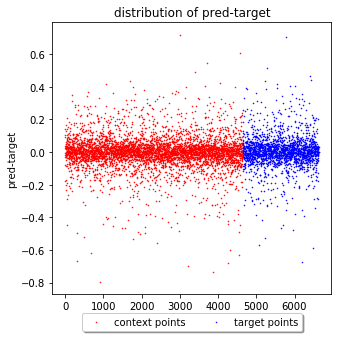

Iteration: 0, train_loss: -0.9892523288726807
Iteration: 0, validation_loss: -0.9959856867790222


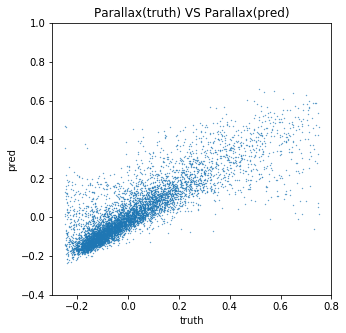

KeyboardInterrupt: 

In [0]:
    TRAINING_ITERATIONS = 2000 #@param {type:"number"}
    PLOT_AFTER = 500 #@param {type:"number"}
    #HIDDEN_SIZE = random.choice([16, 32, 64, 128,256])
    HIDDEN_SIZE = 128
    MODEL_TYPE = 'NP' #@param ['NP','ANP']
    ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
    random_kernel_parameters=True #@param {type:"boolean"}
    outc = 64
    tf.reset_default_graph()

    # Sizes of the layers of the MLPs for the encoders and decoder
    # The final output layer of the decoder outputs two values, one for the mean and
    # one for the variance of the prediction at the target location
    latent_encoder_output_sizes = [HIDDEN_SIZE]*4
    num_latents = HIDDEN_SIZE
    deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
    decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
    use_deterministic_path = False

    # ANP with multihead attention
    if MODEL_TYPE == 'ANP':
      attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                            att_type='multihead')
    # NP - equivalent to uniform attention
    elif MODEL_TYPE == 'NP':
      attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
    else:
      raise NameError("MODEL_TYPE not among ['ANP,'NP']")

    # Define the model
    model = LatentModel(latent_encoder_output_sizes, num_latents,
                        decoder_output_sizes, outc, use_deterministic_path, #outc between decoder and use
                        deterministic_encoder_output_sizes, attention)
    print("start wrapping data...")
    # Define data
    batch_size = 100
    #batch_size =  random.choice([5, 10, 25, 50, 100, 200, 400])
    print("start wrapping training data...")
    train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)
    print("finish...")
    print("start wrapping testing data")
    test_query, test_target_y, test_num_total_points, test_num_context_points = testdatawrap(test_norm_x, test_norm_y, test_norm_x.shape[0])
    print("finish wrapping data...")
    # Define the loss
    _, _, log_prob, LL, _, loss = model(train_query, train_num_total_points,
                                     train_target_y)

    # Get the predicted mean and variance at the target points for the testing set
    mu, sigma, _, _, _, validation_loss = model(test_query, test_num_total_points, test_target_y = test_target_y)

    # Set up the optimizer and train step
    optimizer = tf.train.AdamOptimizer(1e-3)
    global_step = tf.train.get_or_create_global_step()
    train_step = optimizer.minimize(loss, global_step=global_step)
    init = tf.initialize_all_variables()

    LL_set = []
    LL_set_x = []
    train_losses, test_losses = [],[]
    best_train_loss = 99
    best_val_loss = 99
    print("start doing prediction...")
    saver = tf.train.Saver(max_to_keep=1)
    # Train and plot
    with tf.train.MonitoredTrainingSession(checkpoint_dir="./model/model.ckpt", save_checkpoint_secs=600) as sess:
      sess.run(init)
      
      ckpt = tf.train.get_checkpoint_state("./model/model.ckpt")
      if ckpt and ckpt.model_checkpoint_path:
            # Restores from checkpoint
        saver.restore(sess, ckpt.model_checkpoint_path)
      
      for it in range(TRAINING_ITERATIONS):
        sess.run([train_step])

        # Plot the predictions in `PLOT_AFTER` intervals
        if it % PLOT_AFTER == 0:
          validation_loss_value, loss_value, pred_y, std_y, target_y, whole_query, LL_value = sess.run(
              [validation_loss, loss, mu, sigma, test_target_y, 
               test_query, LL])

          # record LL in each itr
          LL_set.append(LL_value)
          #LL_set_X.append(itr)

          plt.figure(figsize=(5,5)) 
          ratio_ct = 0.7
          con_y = pred_y[:,:int(ratio_ct * test_num_total_points)] - target_y[:,:int(ratio_ct * test_num_total_points)]
          tar_y = pred_y[:,int(ratio_ct * test_num_total_points):] - target_y[:,int(ratio_ct * test_num_total_points):]
          X1 = np.arange(int(ratio_ct * test_num_total_points))
          X2 = np.arange(int(ratio_ct * test_num_total_points),test_num_total_points)
          s_con = plt.scatter(X1,con_y,color='red',s=0.3,label='context points')
          s_tar = plt.scatter(X2,tar_y,color='blue',s=0.3,label='target points')
          plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=4)
          plt.xlabel('')
          plt.ylabel('pred-target')
          plt.title(r'distribution of pred-target')
          plt.show()

          (context_x, context_y), target_x = whole_query
          print('Iteration: {}, train_loss: {}'.format(it, loss_value))
          print('Iteration: {}, validation_loss: {}'.format(it, validation_loss_value))
            
          plt.figure(figsize=(5,5)) 
          plt.scatter(target_y, pred_y, s=0.1)
          plt.xlabel('truth')
          plt.ylabel('pred')
          plt.ylim(-0.4,1)
          plt.title(r'Parallax(truth) VS Parallax(pred)')
          plt.show()
        
          train_losses.append(loss_value)
          test_losses.append(validation_loss_value)
          if loss_value < best_train_loss:
            best_train_loss = loss_value
          if validation_loss_value < best_val_loss:
            best_val_loss = validation_loss_value

    print('best training loss:')
    print(best_train_loss)
    print('best validation loss:')
    print(best_val_loss)
    print('hidden size:')
    print(HIDDEN_SIZE)
    print('batch size:')
    print(batch_size)


# MLAnalysis

## 1. RMSE

In [0]:
# RMSE = sqrt(1/N * sum(  (d_true - d_pred)/d_true))^2 )
def cal_RMSE(true, prediction):
    return np.sqrt((1/(true.shape[0])) * np.square(np.sum((true-prediction)/true)))

## 2. Bias

In [0]:
# BIAS = 1/N * sum( (d_true-d_pred)/d_true )
def cal_bias(true, prediction):
    return (1/(true.shape[0])) * np.sum(np.sum((true-prediction)/true))

## 3. SIGMA_NMAD

In [0]:
# SIGMA_NMAD = 1.48 * median(d_true-d_pred)/d_true)
def cal_sigma_nmad(true, prediction):
    return 1.48 * np.median((true-prediction)/true)

## 4. fraction_of_outliers

In [0]:
def cal_fraction_of_outliers(true, prediction):
    res = np.abs(true-prediction)
    outlier_sigmas = 0.3
    spread = np.std(res)
    print(spread)
    return np.sum(res > (outlier_sigmas*spread))

cal_fraction_of_outliers(np.array([1,2,3]),np.array([2,3,4]))

0.0


3

# my  model

In [0]:
class ConvEncoder(object):
  def __init__(self, num_latents, output_sizes, outc):
    """Convolutional encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      num_latents: The latent dimensionality.
    """
    self._num_latents = num_latents
    self.conv = Conv2D(2, kernel_size=1)
    self.conv1 = Conv2D(2, kernel_size=1)
    self._output_sizes = output_sizes
    self.conv2 = Conv2D(outc, kernel_size=1)
    self.conv2a = Conv2D(outc, kernel_size=1)

    self.conv2b = Conv2D(outc, kernel_size=1)

    self.conv2c = Conv2D(outc, kernel_size=1, activation='relu')

    self.flatten = Flatten()

  def __call__(self, x, y):
    """Encodes the inputs into one representation.

    Args:
      x: Tensor of shape [B, N, H, W, C]. For this 1D regression
          task this corresponds to the x-values.
      y: Tensor of shape [B, N, d_y]. For this 1D regression
          task this corresponds to the y-values.

    Returns:
      A normal distribution over tensors of shape [B, num_latents]
    """
    # Have further MLP layers that map to the parameters of the Gaussian latent
    def acn(x):
        eps = 1e-5
        acn = True
        if acn:
            attention = self.conv1(x)
            att1 = tf.reshape(attention[:,:,:,0], (attention.shape[0], -1))
            att2 = tf.reshape(attention[:,:,:,1], (attention.shape[0], -1))
            a_l = tf.nn.sigmoid(att1, name='sigmoid')
            a_r = tf.nn.softmax(att2, axis=1)
            
            a = a_l * a_r
            
        else:
            a = tf.ones([x.shape[0], x.shape[1] * x.shape[2]], tf.float32)
        a = a/(tf.reduce_sum(a, 1)[..., None] + eps)
        #a = a / (a.sum(dim=1)[..., None] + eps)
        #a = a.view(x.shape[0], 1, x.shape[2], x.shape[3])
        
        a = tf.reshape(a,((x.shape[0], x.shape[1], x.shape[2], 1)))
        
        #mean = torch.sum(x * a, dim=(2, 3), keepdim=True)
        mean = tf.reduce_sum(x*a, (1,2), keepdims=True)
        
        out = x - mean
        #std = torch.sqrt(torch.sum(a * out**2, dim=(2, 3), keepdim=True) + eps)
        std = tf.sqrt(tf.reduce_sum(a * out**2, (1,2), keepdims=True) + eps)
        out = out / std
        return out
    
    def acn2(x):
        eps = 1e-5
        acn = True

        if acn:
            attention = self.conv(x)
            att1 = tf.reshape(attention[:,:,:,0], (attention.shape[0], -1))
            att2 = tf.reshape(attention[:,:,:,1], (attention.shape[0], -1))
            a_l = tf.nn.sigmoid(att1, name='sigmoid')
            a_r = tf.nn.softmax(att2, axis=1)
            
            a = a_l * a_r
            
        else:
            a = tf.ones([x.shape[0], x.shape[1] * x.shape[2]], tf.float32)
            
        a = a/(tf.reduce_sum(a, 1)[..., None] + eps)
        #a = a / (a.sum(dim=1)[..., None] + eps)
        #a = a.view(x.shape[0], 1, x.shape[2], x.shape[3])
        
        a = tf.reshape(a,((x.shape[0], x.shape[1], x.shape[2], 1)))
        
        #mean = torch.sum(x * a, dim=(2, 3), keepdim=True)
        mean = tf.reduce_sum(x*a, (1,2), keepdims=True)
        
        return mean
    
    def acn3(x):
        eps = 1e-5
        acn = True

        if acn:
            attention = self.conv1(x)
            att1 = tf.reshape(attention[:,:,:,0], (attention.shape[0], -1))
            att2 = tf.reshape(attention[:,:,:,1], (attention.shape[0], -1))
            a_l = tf.nn.sigmoid(att1, name='sigmoid')
            a_r = tf.nn.softmax(att2, axis=1)
            
            a = a_l * a_r
            
        else:
            a = tf.ones([x.shape[0], x.shape[1] * x.shape[2]], tf.float32)
            
        a = a/(tf.reduce_sum(a, 1)[..., None] + eps)
        #a = a / (a.sum(dim=1)[..., None] + eps)
        #a = a.view(x.shape[0], 1, x.shape[2], x.shape[3])
        
        a = tf.reshape(a,((x.shape[0], x.shape[1], x.shape[2], 1)))
        
        #mean = torch.sum(x * a, dim=(2, 3), keepdim=True)
        mean = tf.reduce_sum(x*a, (1,2), keepdims=True)
        
        return mean
    
    with tf.Session():
        X = x.eval()
        #y = y.eval()

    #X = np.reshape(X, (x.shape[0]*x.shape[1], x.shape[2], x.shape[3], x.shape[4]))
    X = np.reshape(X, (x.shape[0]*x.shape[1], x.shape[2], x.shape[3], -1))
    #y = np.reshape(y, (y.shape[0]*y.shape[1], y.shape[2]))
    
    X = tf.convert_to_tensor(X, np.float32)
    #y = tf.convert_to_tensor(y, np.float32)
    with tf.variable_scope("conv_encoder", reuse=tf.AUTO_REUSE):
      #X = self.conv2(X)
      X = self.conv2a(X)
      X = self.conv2b(X)
      X = self.conv2c(X)
      X = acn2(X)
      X = self.flatten(X)
      X = tf.reshape(X,(x.shape[0], x.shape[1], X.shape[1]))
      X = tf.concat([X, y], axis=-1)
    
    hidden = batch_mlp(X, self._output_sizes, "latent_encoder")

    # Aggregator: take the mean over all points
    hidden = tf.reduce_mean(hidden, axis=1)
    
    # Have further MLP layers that map to the parameters of the Gaussian latent
    with tf.variable_scope("latent_encoder", reuse=tf.AUTO_REUSE):
      # First apply intermediate relu layer 
      hidden = tf.nn.relu(
          tf.layers.dense(hidden, 
                          (self._output_sizes[-1] + self._num_latents)/2,
                          name="penultimate_layer"))
      # Then apply further linear layers to output latent mu and log sigma
      mu = tf.layers.dense(hidden, self._num_latents, name="mean_layer")
      log_sigma = tf.layers.dense(hidden, self._num_latents, name="std_layer")
      
    # Compute sigma
    sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)

    return tf.contrib.distributions.Normal(loc=mu, scale=sigma)

In [0]:
class LatentModel(object):
  """The (A)NP model."""

  def __init__(self, latent_encoder_output_sizes, num_latents,
               decoder_output_sizes, outc, use_deterministic_path=True, 
               deterministic_encoder_output_sizes=None, attention=None):
    """Initialises the model.

    Args:
      latent_encoder_output_sizes: An iterable containing the sizes of hidden 
          layers of the latent encoder.
      num_latents: The latent dimensionality.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to d_y * 2
          (it encodes both mean and variance concatenated)
      use_deterministic_path: a boolean that indicates whether the deterministic
          encoder is used or not.
      deterministic_encoder_output_sizes: An iterable containing the sizes of 
          hidden layers of the deterministic encoder. The last one is the size 
          of the deterministic representation r.
      attention: The attention module used in the deterministic encoder.
          Only relevant when use_deterministic_path=True.
    """
    self._conv_encoder = ConvEncoder(num_latents, latent_encoder_output_sizes, outc)
    self._decoder = Decoder(decoder_output_sizes)
    self._use_deterministic_path = use_deterministic_path
    if use_deterministic_path:
      self._deterministic_encoder = DeterministicEncoder(
          deterministic_encoder_output_sizes, attention)
    

  def __call__(self, query, num_targets, target_y=None, test_target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Tensor of shape [B,num_contexts,d_x]. 
              Contains the x values of the context points.
          context_y: Tensor of shape [B,num_contexts,d_y]. 
              Contains the y values of the context points.
          target_x: Tensor of shape [B,num_targets,d_x]. 
              Contains the x values of the target points.
      num_targets: Number of target points.
      target_y: The ground truth y values of the target y. 
          Tensor of shape [B,num_targets,d_y].

    Returns:
      log_p: The log_probability of the target_y given the predicted
          distribution. Tensor of shape [B,num_targets].
      mu: The mean of the predicted distribution. 
          Tensor of shape [B,num_targets,d_y].
      sigma: The variance of the predicted distribution.
          Tensor of shape [B,num_targets,d_y].
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    prior = self._conv_encoder(context_x, context_y)
    
    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    if target_y is None:
      latent_rep = prior.sample()
    # For testing, when target_y unavailable, use contexts for latent encoder.
    else:
      posterior = self._conv_encoder(target_x, target_y)
      latent_rep = posterior.sample()
    latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                         [1, num_targets, 1])
    if self._use_deterministic_path:
      deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                      target_x)
      representation = tf.concat([deterministic_rep, latent_rep], axis=-1)
    else:
      representation = latent_rep

    dist, mu, sigma = self._decoder(representation, target_x)
    
    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      posterior = self._conv_encoder(target_x, target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      LL = tf.reduce_mean(log_p, keep_dims=False)
    else:
      log_p = dist.log_prob(test_target_y)
      posterior = self._conv_encoder(target_x, test_target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      #validation_context_loss = - tf.reduce_mean(log_p[:,int(0.5*num_targets):] - kl / tf.cast(num_targets, tf.float32))
      #validation_noncontext_loss =  - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      LL = None
        #con_y = pred_y[:,:int(0.5 * test_num_total_points)] - target_y[:,:int(0.5 * test_num_total_points)]
      #tar_y = pred_y[:,int(0.5 * test_num_total_points):] - target_y[:,int(0.5 * test_num_total_points):]

    return mu, sigma, log_p, LL, kl, loss

In [0]:
class Decoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """(A)NP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes
    self._num_latents = 128
    self.conv = Conv2D(2, kernel_size=1)
    self.conv1 = Conv2D(2, kernel_size=1)
    outc = 64
    self.conv2 = Conv2D(outc, kernel_size=1)
    self.conv2a = Conv2D(outc, kernel_size=1)

    self.conv2b = Conv2D(outc, kernel_size=1)

    self.conv2c = Conv2D(outc, kernel_size=1, activation='relu')

    self.flatten = Flatten()

  def __call__(self, representation, target_x):
    """Decodes the individual targets.

    Args:
      representation: The representation of the context for target predictions. 
          Tensor of shape [B,target_observations,?].
      target_x: The x locations for the target query.
          Tensor of shape [B,target_observations,d_x].

    Returns:
      dist: A multivariate Gaussian over the target points. A distribution over
          tensors of shape [B,target_observations,d_y].
      mu: The mean of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
      sigma: The standard deviation of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
    """
    # concatenate target_x and representation
    def acn(x):
        eps = 1e-5
        acn = True
        if acn:
            attention = self.conv1(x)
            att1 = tf.reshape(attention[:,:,:,0], (attention.shape[0], -1))
            att2 = tf.reshape(attention[:,:,:,1], (attention.shape[0], -1))
            a_l = tf.nn.sigmoid(att1, name='sigmoid')
            a_r = tf.nn.softmax(att2, axis=1)
            
            a = a_l * a_r
            
        else:
            a = tf.ones([x.shape[0], x.shape[1] * x.shape[2]], tf.float32)
            
        a = a/(tf.reduce_sum(a, 1)[..., None] + eps)
        #a = a / (a.sum(dim=1)[..., None] + eps)
        #a = a.view(x.shape[0], 1, x.shape[2], x.shape[3])
        
        a = tf.reshape(a,((x.shape[0], x.shape[1], x.shape[2], 1)))
        #mean = torch.sum(x * a, dim=(2, 3), keepdim=True)
        mean = tf.reduce_sum(x*a, (1,2), keepdims=True)
        out = x - mean
        #std = torch.sqrt(torch.sum(a * out**2, dim=(2, 3), keepdim=True) + eps)
        std = tf.sqrt(tf.reduce_sum(a * out**2, (1,2), keepdims=True) + eps)
        out = out / std
        return out
    
    def acn2(x):
        eps = 1e-5
        acn = True
        if acn:
            attention = self.conv(x)
            att1 = tf.reshape(attention[:,:,:,0], (attention.shape[0], -1))
            att2 = tf.reshape(attention[:,:,:,1], (attention.shape[0], -1))
            a_l = tf.nn.sigmoid(att1, name='sigmoid')
            a_r = tf.nn.softmax(att2, axis=1)
            
            a = a_l * a_r
            
        else:
            a = tf.ones([x.shape[0], x.shape[1] * x.shape[2]], tf.float32)

        a = a/(tf.reduce_sum(a, 1)[..., None] + eps)
        #a = a / (a.sum(dim=1)[..., None] + eps)
        #a = a.view(x.shape[0], 1, x.shape[2], x.shape[3])
        
        a = tf.reshape(a,((x.shape[0], x.shape[1], x.shape[2], 1)))
        
        #mean = torch.sum(x * a, dim=(2, 3), keepdim=True)
        mean = tf.reduce_sum(x*a, (1,2), keepdims=True)
        
        return mean 
    
    def acn3(x):
        eps = 1e-5
        acn = True

        if acn:
            attention = self.conv1(x)
            att1 = tf.reshape(attention[:,:,:,0], (attention.shape[0], -1))
            att2 = tf.reshape(attention[:,:,:,1], (attention.shape[0], -1))
            a_l = tf.nn.sigmoid(att1, name='sigmoid')
            a_r = tf.nn.softmax(att2, axis=1)
            
            a = a_l * a_r
            
        else:
            a = tf.ones([x.shape[0], x.shape[1] * x.shape[2]], tf.float32)
            
        a = a/(tf.reduce_sum(a, 1)[..., None] + eps)
        #a = a / (a.sum(dim=1)[..., None] + eps)
        #a = a.view(x.shape[0], 1, x.shape[2], x.shape[3])
        
        a = tf.reshape(a,((x.shape[0], x.shape[1], x.shape[2], 1)))
        
        #mean = torch.sum(x * a, dim=(2, 3), keepdim=True)
        mean = tf.reduce_sum(x*a, (1,2), keepdims=True)
        
        return mean   
    
    x = target_x
    
    with tf.Session():
        X = x.eval()
        #y = y.eval()

    #X = np.reshape(X, (x.shape[0]*x.shape[1], x.shape[2], x.shape[3], x.shape[4]))
    X = np.reshape(X, (x.shape[0]*x.shape[1], x.shape[2], x.shape[3], -1))
    #y = np.reshape(y, (y.shape[0]*y.shape[1], y.shape[2]))
    
    X = tf.convert_to_tensor(X, np.float32)
    #y = tf.convert_to_tensor(y, np.float32)

    with tf.variable_scope("conv_encoder", reuse=tf.AUTO_REUSE):
      #X = self.conv2(X)
      X = self.conv2a(X)
      X = self.conv2b(X)
      X = self.conv2c(X)
      X = acn2(X)
      X = self.flatten(X)
      X = tf.reshape(X,(x.shape[0], x.shape[1], X.shape[1]))
      #X = tf.concat([X, y], axis=-1)
    target_x = tf.reshape(target_x, (target_x.shape[0], target_x.shape[1], -1))

    hidden = tf.concat([representation, X], axis=-1)
    #print(representation.shape)
    #hidden = target_x
    #hidden = representation
    
    # Pass final axis through MLP
    hidden = batch_mlp(hidden, self._output_sizes, "decoder")

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma